# NeuralProphet Nuovi Positivi, Terapia Intensiva, Deceduti

In questo notebook sono stati utlizzati gli stessi dati del notebook https://colab.research.google.com/github/marco-mazzoli/progetto-tesi/blob/master/covid_multi_output.ipynb, ossia quelli regionali dell'Emilia-Romagna.
Sono in particolare stati usati i dati di ricoverati in terapia intensiva, deceduti e nuovi positivi fino al 6 Dicembre 2021.

Il modello NeuralProphet è stato utilizzato in modalità univariate ed autoregressiva con lag di 28 giorni per fare forecasting di 1, 2, 7 e 14 giorni.

L'ultimo 20% dei dati è stato escluso dalla fase di ricerca degli iper-parametri. Una volta stabiliti è stato usato l'intero dataset per fare previsione mantendo il primo 80% di train e il restante di test.

Gli iper-parametri su cui è stata fatta la ricerca sono learning-rate e numero di layer hidden della rete neurale.

Prima della fase di train i dati vengono scalati per poi essere riportati alla scala originale una volta effettuata la previsione.

Questo modello crea automaticamente i lag temporali.

In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/marco-mazzoli/neural_prophet.git

In [286]:
import os

if 'google.colab' in str(get_ipython()):
    files = ['util.py',
             'windows.py',
             'models']

    for file in files:
        os.system('rm ./' + file)
        os.system(
            'wget -nv https://raw.githubusercontent.com/marco-mazzoli/progetto-tesi/master/' + file)

import pandas as pd
from numpy.random import seed
from neuralprophet import NeuralProphet
import numpy as np

from util import select_relevant_rows, select_attributes



In [287]:
use_existing_config = True
column_to_predict = 'terapia_intensiva'
columns = ['nuovi_positivi', 'terapia_intensiva', 'deceduti']
split_percent = 0.80
region_focus = 'Emilia-Romagna'
attribute_focus = 'denominazione_regione'
n_futures = [1, 2, 7, 14]


In [288]:
local_region_path = r'../COVID-19/dati-regioni/dpc-covid19-ita-regioni.csv'
remote_region_path = r'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'

regions_frame = pd.read_csv(remote_region_path)

region_focus_data = select_relevant_rows(
    regions_frame,
    attribute_focus,
    region_focus
)

df = select_attributes(region_focus_data, [
    'data',
    'ricoverati_con_sintomi',
    'terapia_intensiva',
    'totale_ospedalizzati',
    'variazione_totale_positivi',
    'nuovi_positivi',
    'deceduti',
    'tamponi',
    'ingressi_terapia_intensiva'
])

df = pd.DataFrame(df)
df['data'] = pd.to_datetime(
    df['data'])
df['data'] = df['data'].dt.strftime(
    r'%Y-%m-%d')
df['data'] = pd.to_datetime(df['data'])
df = df[df['data'] < pd.to_datetime('2022-01-31')]
df = df.fillna(0)

df.rename(columns={'data': 'date'}, inplace=True)
df.set_index('date', inplace=True)

# revert cumulative data
df['deceduti'] = df['deceduti'].diff(
)
df['tamponi'] = df['tamponi'].diff(
)

df = df.astype('float')

# numpy seed
seed(1)

In [289]:
def define_np_configs():
    learning_rate = [0.001, 0.01, 0.05, 0.1]
    n_hidden = [0, 1, 2]

    configs = []
    keys = ['learning_rate', 'n_hidden']

    for i in learning_rate:
        for j in n_hidden:   
            config = dict(
                zip(keys, (i, j)))
            configs.append(config)

    return configs

In [290]:
def compute_mape(forecast, n_future):
    frcst = forecast.copy()
    frcst['y'][frcst['y'] == 0] = 0.1
    for i in range(n_future):
        frcst['perc'+str(i+1)] = np.abs(frcst['residual'+str(i+1)] / frcst['y'])

    perc = np.mean(frcst[['perc'+str(i+1) for i in range(n_future)]])
    return perc.mean()

INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.016 549.738 625.254
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.002 212.600 244.754
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss      MAE     RMSE
1         0.129 1723.538 1759.705
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.002 161.528 196.480
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.010 437.867 479.989
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size

0        622.0
1        555.0
2        558.0
3        472.0
4        412.0
        ...   
158    19028.0
159    16142.0
160    16941.0
161    15023.0
162    13091.0
Name: y, Length: 163, dtype: float64


INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.012 454.212 535.659
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.002 175.200 207.349
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.002 173.899 226.523
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.003 205.734 246.364
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.000 74.421 95.426
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Los

0        637.0
1        622.0
2        555.0
3        558.0
4        472.0
        ...   
159    19028.0
160    16142.0
161    16941.0
162    15023.0
163    13091.0
Name: y, Length: 164, dtype: float64


INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss      MAE     RMSE
1         0.045 1016.862 1044.713
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.006 313.800 378.661
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE    RMSE
1         0.001 90.056 117.679
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.010 410.152 482.690
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss      MAE     RMSE
1         0.063 1160.381 1229.673
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    S

0        478.0
1        445.0
2        576.0
3        637.0
4        622.0
        ...   
162    19028.0
163    16142.0
164    16941.0
165    15023.0
166    13091.0
Name: y, Length: 167, dtype: float64


INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.010 434.658 488.067
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.016 556.183 610.968
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.003 228.895 268.617
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.021 614.884 709.470
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.010 437.692 500.893
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL

0        656.0
1        765.0
2        551.0
3        458.0
4        478.0
        ...   
166    19028.0
167    16142.0
168    16941.0
169    15023.0
170    13091.0
Name: y, Length: 171, dtype: float64


INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.018 74.345 76.519
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.002 23.083 26.415
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.002 22.742 26.973
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.004 30.589 36.484
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.001 18.189 20.398
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE


0       46.0
1       47.0
2       52.0
3       54.0
4       55.0
       ...  
158    152.0
159    149.0
160    147.0
161    146.0
162    151.0
Name: y, Length: 163, dtype: float64


INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.000 11.508 12.593
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.004 30.331 34.923
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.005 36.219 38.911
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.000  7.919  8.875
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.002 22.751 26.936
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE


0       44.0
1       46.0
2       47.0
3       52.0
4       54.0
       ...  
159    152.0
160    149.0
161    147.0
162    146.0
163    151.0
Name: y, Length: 164, dtype: float64


INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE    RMSE
1         0.032 99.478 100.580
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.022 76.573 83.753
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.021 79.501 82.584
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.000  6.636  7.906
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.004 34.572 36.885
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMS

0       44.0
1       47.0
2       47.0
3       44.0
4       46.0
       ...  
162    152.0
163    149.0
164    147.0
165    146.0
166    151.0
Name: y, Length: 167, dtype: float64


INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.002 20.825 23.802
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.002 19.120 22.873
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.002 21.412 25.456
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.001 13.599 16.219
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.005 29.977 38.462
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE


0       36.0
1       38.0
2       35.0
3       40.0
4       44.0
       ...  
166    152.0
167    149.0
168    147.0
169    146.0
170    151.0
Name: y, Length: 171, dtype: float64


INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.008 19.239 19.834
INFO - (NP.forecaster._handle_missing_data) - 1 NaN values in column y were auto-imputed.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.021 30.433 31.770
INFO - (NP.forecaster._handle_missing_data) - 1 NaN values in column y were auto-imputed.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.019 27.597 30.132
INFO - (NP.forecaster._handle_missing_data) - 1 NaN values in column y were auto-imputed.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.000  3.314  4.058
INFO - (NP.forecaster._handle_missing_data) - 1 NaN values in colu

0       2.0
1       3.0
2       3.0
3       3.0
4       7.0
       ... 
158    53.0
159    48.0
160    30.0
161    39.0
162    33.0
Name: y, Length: 163, dtype: float64


INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.007 17.282 18.162
INFO - (NP.forecaster._handle_missing_data) - 1 NaN values in column y were auto-imputed.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.001  7.225  7.861
INFO - (NP.forecaster._handle_missing_data) - 1 NaN values in column y were auto-imputed.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.012 21.964 24.011
INFO - (NP.forecaster._handle_missing_data) - 1 NaN values in column y were auto-imputed.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.001  5.822  6.878
INFO - (NP.forecaster._handle_missing_data) - 1 NaN values in colu

0       1.0
1       2.0
2       3.0
3       3.0
4       3.0
       ... 
159    53.0
160    48.0
161    30.0
162    39.0
163    33.0
Name: y, Length: 164, dtype: float64


INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.000  2.310  3.024
INFO - (NP.forecaster._handle_missing_data) - 1 NaN values in column y were auto-imputed.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.045 46.065 46.454
INFO - (NP.forecaster._handle_missing_data) - 1 NaN values in column y were auto-imputed.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.004 12.978 14.468
INFO - (NP.forecaster._handle_missing_data) - 1 NaN values in column y were auto-imputed.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.019 26.334 30.109
INFO - (NP.forecaster._handle_missing_data) - 1 NaN values in colu

0       7.0
1       3.0
2       3.0
3       1.0
4       2.0
       ... 
162    53.0
163    48.0
164    30.0
165    39.0
166    33.0
Name: y, Length: 167, dtype: float64


INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.005 14.243 15.332
INFO - (NP.forecaster._handle_missing_data) - 1 NaN values in column y were auto-imputed.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.001  4.052  4.945
INFO - (NP.forecaster._handle_missing_data) - 1 NaN values in column y were auto-imputed.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.046 45.741 46.820
INFO - (NP.forecaster._handle_missing_data) - 1 NaN values in column y were auto-imputed.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.029 31.852 37.244
INFO - (NP.forecaster._handle_missing_data) - 1 NaN values in colu

0       3.0
1       4.0
2       1.0
3       2.0
4       7.0
       ... 
166    53.0
167    48.0
168    30.0
169    39.0
170    33.0
Name: y, Length: 171, dtype: float64


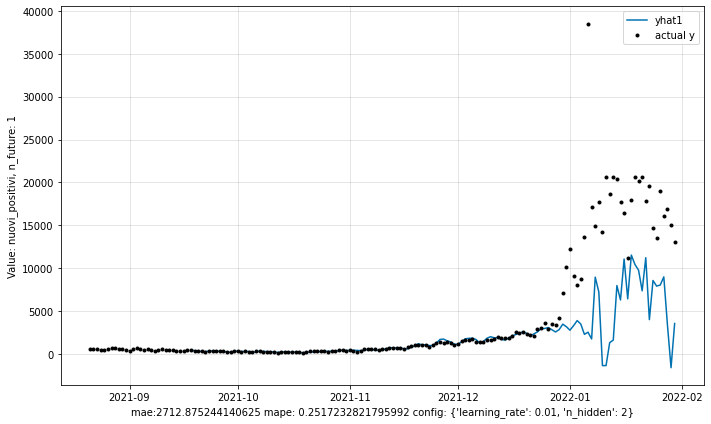

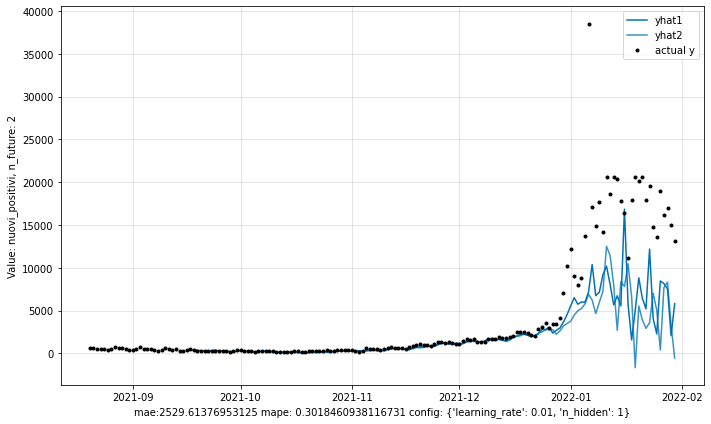

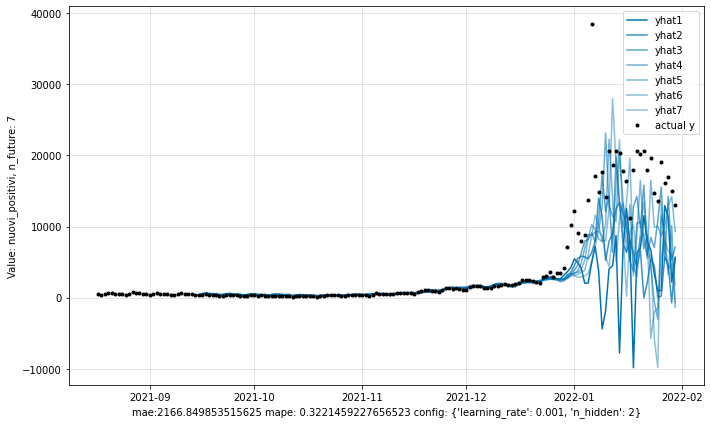

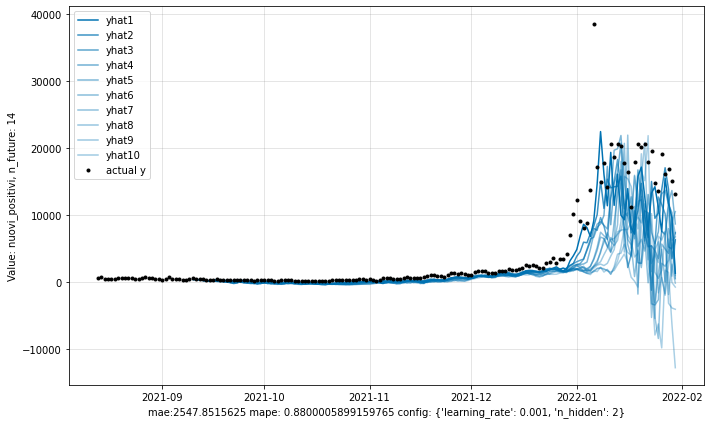

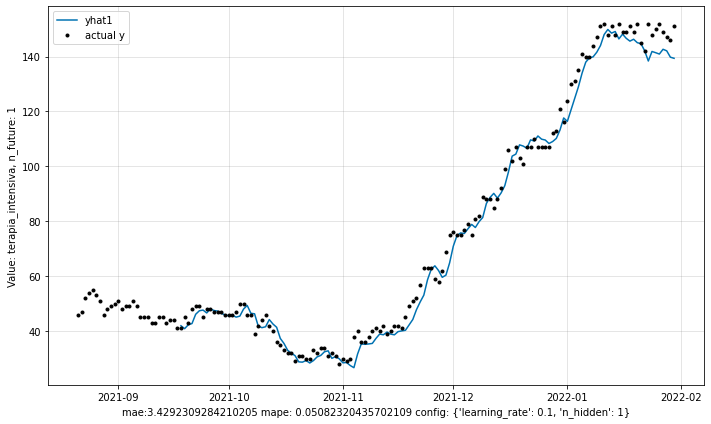

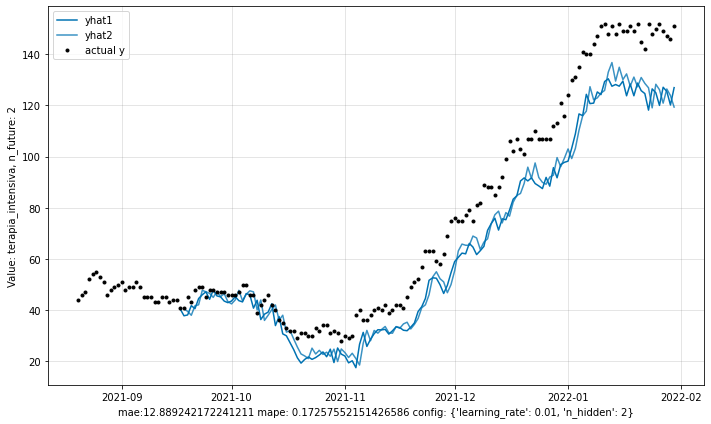

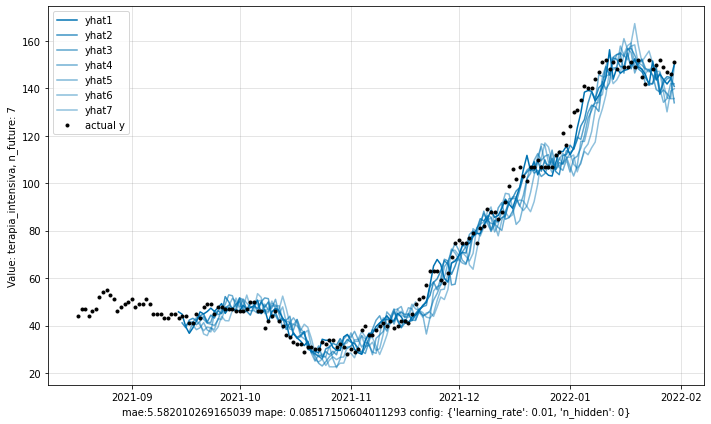

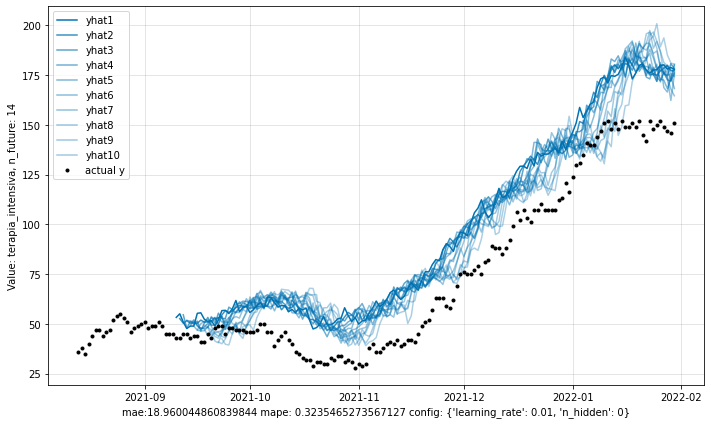

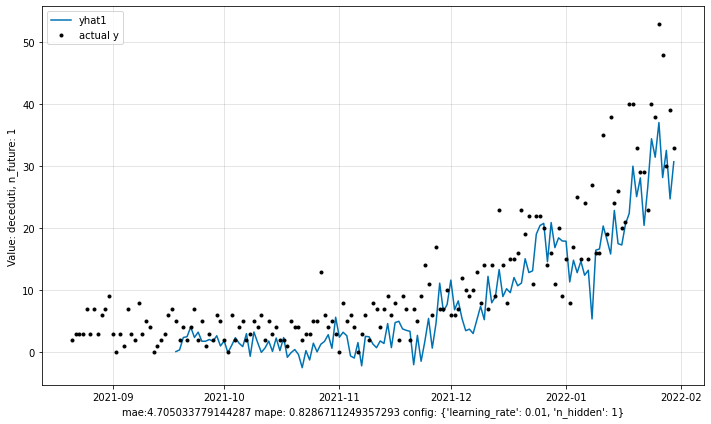

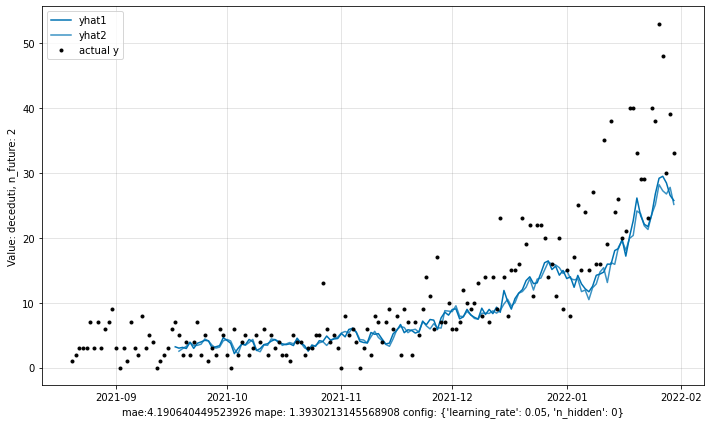

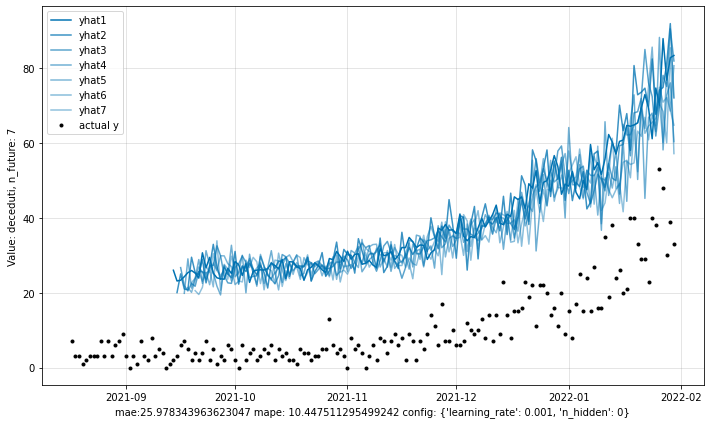

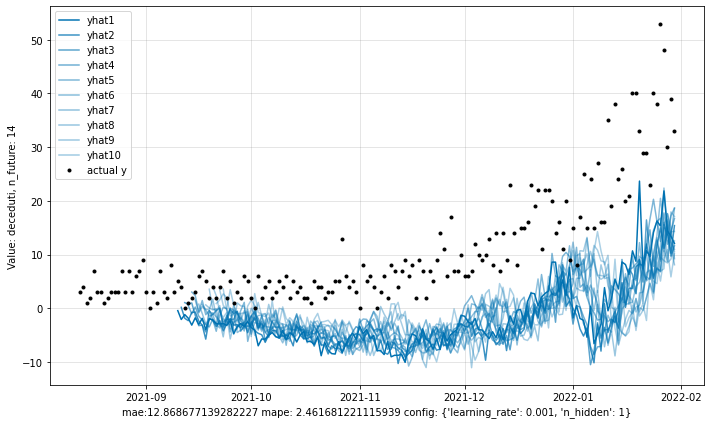

In [291]:
table_result = pd.DataFrame(columns=['mae', 'mape'])

for column_to_predict in columns:
    for n_future in n_futures:
        split = int(split_percent * len(df))
        
        current = df[[column_to_predict]].reset_index().copy()
        current.columns = ['ds', 'y']

        holdout = current[:split]
        results = []

        for config in define_np_configs():
            m = NeuralProphet(
                n_lags=28,
                epochs=200,
                n_forecasts=n_future,
                weekly_seasonality=False,
                changepoints_range=1,
                daily_seasonality=False,
                yearly_seasonality=False,
                learning_rate=config['learning_rate'],
                num_hidden_layers=config['n_hidden'],
                normalize='minmax'
            )

            df_train, df_test = m.split_df(df=holdout, freq="D", valid_p=1-split_percent)

            metrics_train = m.fit(df=df_train, validation_df=df_test,freq="D", progress_print=False, progress_bar=False)
            metrics_test = m.test(df=df_test)

            mae = metrics_test['MAE'][0]

            results.append((mae, config))
    
        results.sort()
        best_config = results[0][-1]

        m = NeuralProphet(
            n_lags=28,
            epochs=200,
            n_forecasts=n_future,
            weekly_seasonality=False,
            changepoints_range=1,
            daily_seasonality=False,
            yearly_seasonality=False,
            learning_rate=best_config['learning_rate'],
            num_hidden_layers=best_config['n_hidden'],
            normalize='minmax'
        )

        df_train, df_test = m.split_df(df=current, freq="D", valid_p=1-split_percent)

        metrics_train = m.fit(df=df_train, validation_df=df_test,freq="D", progress_print=False, progress_bar=False)
        metrics_test = m.test(df=df_test)

        forecast = m.predict(df=df_test)

        print(forecast['y'])

        mae = metrics_test['MAE'][0]
        mape = compute_mape(forecast, n_future)

        ylabel = 'Value: ' + column_to_predict + ', n_future: ' + str(n_future)
        xlabel =  'mae:' + str(mae) + ' mape: ' + str(mape) + ' config: ' + str(best_config)

        m.plot(forecast, ylabel=ylabel, xlabel=xlabel)

        
        values_to_add = {'mae': mae, 'mape':mape}
        row_to_add = pd.Series(values_to_add, name = column_to_predict + ' ' + str(n_future))

        table_result = table_result.append(row_to_add)


In [292]:
print(table_result)

                              mae       mape
nuovi_positivi 1      2712.875244   0.251723
nuovi_positivi 2      2529.613770   0.301846
nuovi_positivi 7      2166.849854   0.322146
nuovi_positivi 14     2547.851562   0.880001
terapia_intensiva 1      3.429231   0.050823
terapia_intensiva 2     12.889242   0.172576
terapia_intensiva 7      5.582010   0.085172
terapia_intensiva 14    18.960045   0.323547
deceduti 1               4.705034   0.828671
deceduti 2               4.190640   1.393021
deceduti 7              25.978344  10.447511
deceduti 14             12.868677   2.461681
